In [17]:
# %%
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import STL
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Leitura e pré-processamento dos dados
data = pd.read_csv("dataset.csv")
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0]) 
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce') 
data.set_index('id_datetime', inplace=True)
data.drop(columns=['id_str'], inplace=True)
variables = pd.DataFrame(index=data.index)

# Filtragem de ruído com wavelet
def wavelet_denoising(signal, wavelet='bior2.2', level=3):
    coeffs = pywt.wavedec(signal, wavelet, mode='periodization', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='hard') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='periodization')
    return reconstructed_signal[:len(signal)]

columns_to_denoise = ['ws100', 'humid', 'wdisp100', 'temp', 'vertdisp100', 'wdir100']
for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = data[col].values
        variables[f'{col}_wavelet'] = denoised_signal  
    else:
        raise ValueError(f"A coluna '{col}' não existe no dataset.")

# Extração de características estatísticas básicas
def basic_statistics(df, window=36):
    stats_df = pd.DataFrame(index=df.index)
    for col in df.columns:
        stats_df[f'{col}_mean'] = df[col].rolling(window=window, min_periods=1).mean()
        stats_df[f'{col}_var'] = df[col].rolling(window=window, min_periods=1).var()
        stats_df[f'{col}_skew'] = df[col].rolling(window=window, min_periods=1).skew()
        stats_df[f'{col}_kurt'] = df[col].rolling(window=window, min_periods=1).kurt()
    return stats_df

stats_features = basic_statistics(variables, window=36)
variables = pd.concat([variables, stats_features], axis=1)

# Teste ADF no 'ws100_wavelet'
def adf_test(series, signif=0.05):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    if p_value < signif:
        return p_value, 'Estacionário'
    else:
        return p_value, 'Não Estacionário'

ws100_series = variables['ws100_wavelet'].dropna()
p_val, decision = adf_test(ws100_series)
print(f"ADF Test p-value: {p_val}")
print(f"Decisão: {decision}")

# Como o lag é fixo em 144, não realizamos a seleção automática de lag
lag = 144
print(f"Lag definido: {lag}")

# Rolling Statistics
def rolling_statistics(df, window=36):
    rolling_df = pd.DataFrame(index=df.index)
    for col in df.columns:
        rolling_df[f'{col}_rolling_mean'] = df[col].rolling(window=window, min_periods=1).mean()
        rolling_df[f'{col}_rolling_std'] = df[col].rolling(window=window, min_periods=1).std()
        rolling_df[f'{col}_rolling_min'] = df[col].rolling(window=window, min_periods=1).min()
        rolling_df[f'{col}_rolling_max'] = df[col].rolling(window=window, min_periods=1).max()
    return rolling_df

rolling_features = rolling_statistics(variables, window=36)
variables = pd.concat([variables, rolling_features], axis=1)

# Extração de features de Fourier
def fourier_features(series, n_components=5):
    series_demeaned = series - np.mean(series)
    fft_vals = fft(series_demeaned)
    fft_freq = fftfreq(len(series_demeaned), d=1)
    pos_mask = fft_freq > 0
    freqs = fft_freq[pos_mask]
    amplitudes = np.abs(fft_vals[pos_mask])
    if len(amplitudes) == 0:
        top_freqs = [np.nan]*n_components
        top_amps = [np.nan]*n_components
    else:
        idx = np.argsort(amplitudes)[-n_components:]
        top_freqs = freqs[idx]
        top_amps = amplitudes[idx]
    features = {}
    for i in range(n_components):
        features[f'fft_freq_{i+1}'] = top_freqs[i] if i < len(top_freqs) else np.nan
        features[f'fft_amp_{i+1}'] = top_amps[i] if i < len(top_amps) else np.nan
    return pd.Series(features)

# Inicializando um DataFrame vazio para armazenar as features de Fourier
fourier_df = pd.DataFrame(index=variables.index)

for col in columns_to_denoise:
    denoised_col = f'{col}_wavelet'
    if denoised_col in variables.columns:
        # Inicializar uma lista para armazenar os resultados
        features_list = []
        
        # Iterar sobre cada janela de rolagem
        for window in variables[denoised_col].rolling(window=36, min_periods=1):
            # Aplicar a função de extração de features
            features = fourier_features(window, n_components=2)
            features_list.append(features)
        
        # Converter a lista de Series em um DataFrame
        fourier_expanded = pd.DataFrame(features_list, index=variables.index)
        
        # Renomear as colunas para identificar a que coluna original pertencem
        fourier_expanded.columns = [f'{denoised_col}_{col_name}' for col_name in fourier_expanded.columns]
        
        # Concatenar as novas features ao DataFrame principal de Fourier
        fourier_df = pd.concat([fourier_df, fourier_expanded], axis=1)
    else:
        raise ValueError(f"A coluna '{denoised_col}' não existe no dataframe 'variables'.")

# Adiciona as features de Fourier ao dataframe 'variables'
variables = pd.concat([variables, fourier_df], axis=1)

# Decomposição STL
def stl_decomposition(series, period=144, seasonal=7):
    stl = STL(series, period=period, robust=True)
    result = stl.fit()
    decomposed = pd.DataFrame({
        'trend': result.trend,
        'seasonal': result.seasonal,
        'residual': result.resid
    }, index=series.index)
    return decomposed

decomposition_df = pd.DataFrame(index=variables.index)
for col in columns_to_denoise:
    denoised_col = f'{col}_wavelet'
    if denoised_col in variables.columns:
        decomposed = stl_decomposition(variables[denoised_col].dropna(), period=36)
        decomposition_df[f'{denoised_col}_trend'] = decomposed['trend']
        decomposition_df[f'{denoised_col}_seasonal'] = decomposed['seasonal']
        decomposition_df[f'{denoised_col}_residual'] = decomposed['residual']
    else:
        raise ValueError(f"A coluna '{denoised_col}' não existe no dataframe 'variables'.")

variables = pd.concat([variables, decomposition_df], axis=1)

# Seleção de features
selector = VarianceThreshold(threshold=0.0)
selector.fit(variables.dropna())
features_selected = variables.columns[selector.get_support()]
variables = variables[features_selected]

# Matriz de Correlação
# Cálculo da matriz de correlação
corr_matrix = variables.corr()

# Extraindo as correlações com 'ws100_wavelet'
ws100_corr = corr_matrix['ws100_wavelet']

# Filtrando as variáveis com correlação >= 0.5 (em valor absoluto) e excluindo a própria 'ws100_wavelet'
high_corr_features = ws100_corr[ws100_corr.abs() >= 0.5].drop('ws100_wavelet')

# Exibindo as correlações filtradas
print("\nFeatures com correlação >= 0.5 (em valor absoluto) com 'ws100_wavelet':\n")
print(high_corr_features)

# Visualização da Matriz de Correlação com Heatmap
# Preparando o DataFrame para o heatmap
high_corr_df = variables[high_corr_features.index.tolist() + ['ws100_wavelet']].corr()


ADF Test p-value: 2.77971555632803e-19
Decisão: Estacionário
Lag definido: 144

Features com correlação >= 0.5 (em valor absoluto) com 'ws100_wavelet':

wdisp100_wavelet                   0.558741
ws100_wavelet_mean                 0.736360
wdisp100_wavelet_mean              0.533715
ws100_wavelet_rolling_mean         0.736360
ws100_wavelet_rolling_min          0.587684
ws100_wavelet_rolling_max          0.711754
wdisp100_wavelet_rolling_mean      0.533715
wdisp100_wavelet_rolling_min       0.512077
ws100_wavelet_mean_rolling_mean    0.606948
ws100_wavelet_mean_rolling_min     0.634850
ws100_wavelet_mean_rolling_max     0.640015
ws100_wavelet_trend                0.825677
ws100_wavelet_residual             0.558717
wdisp100_wavelet_trend             0.641911
Name: ws100_wavelet, dtype: float64


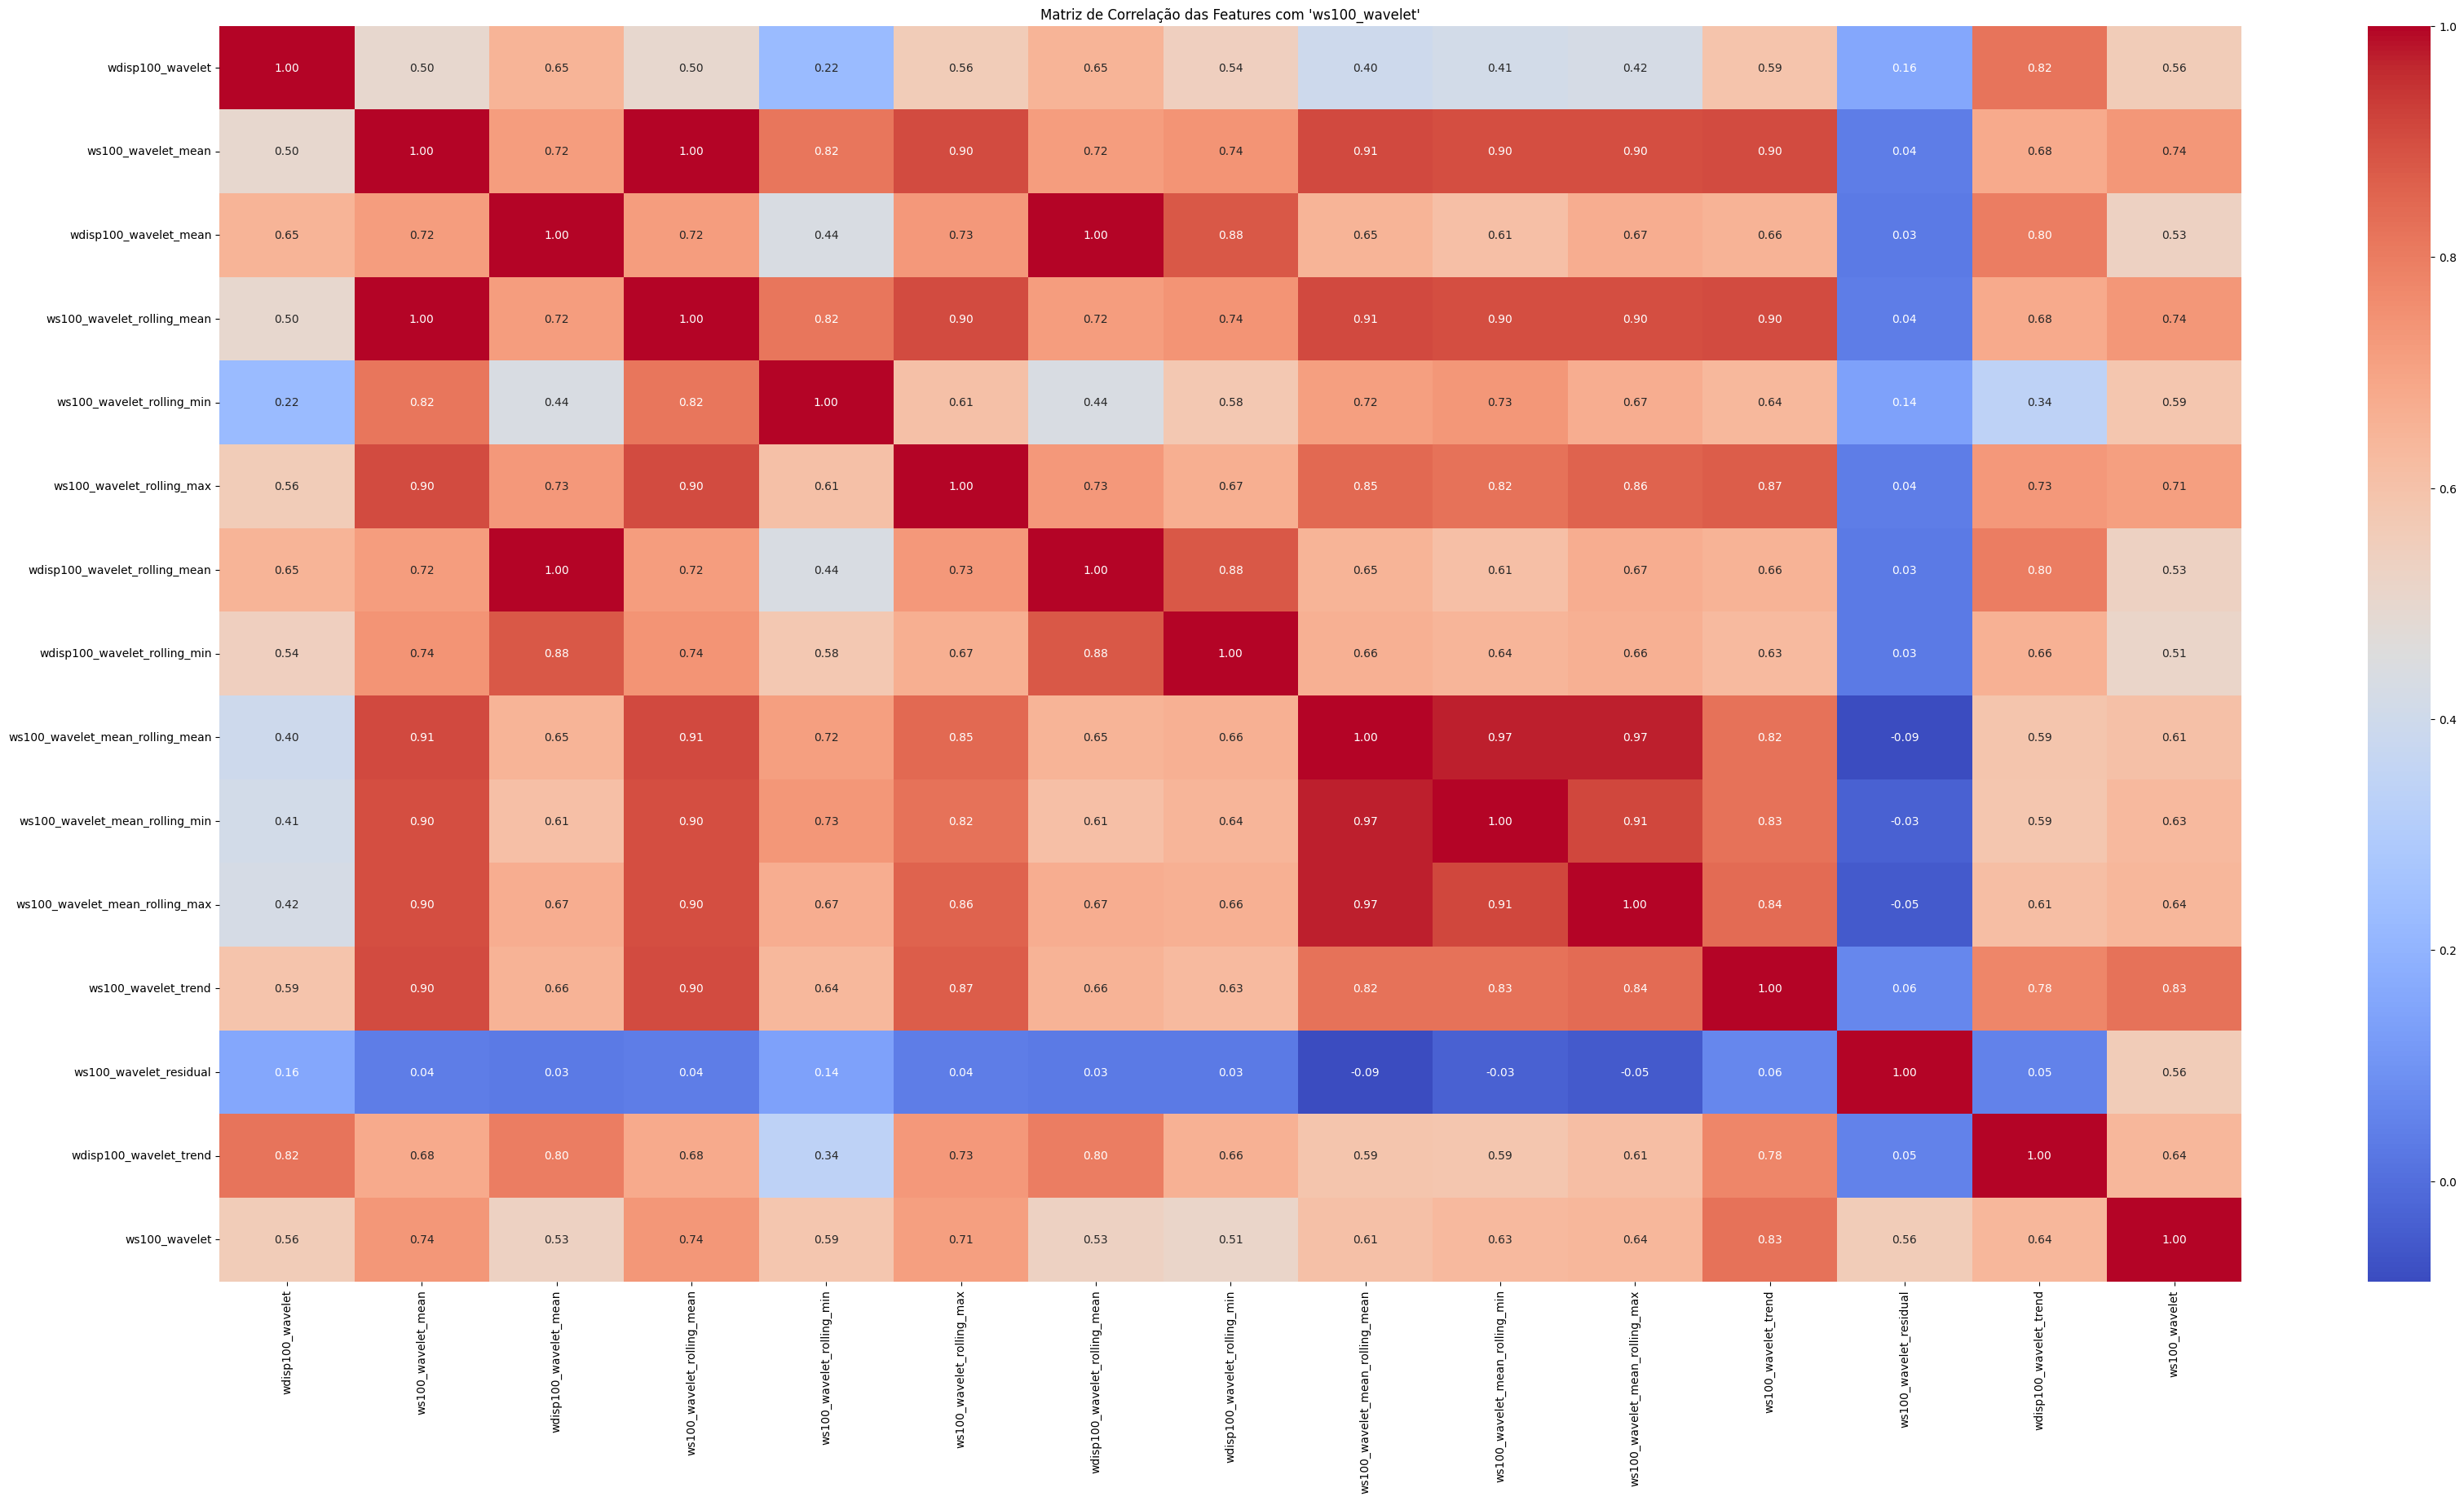

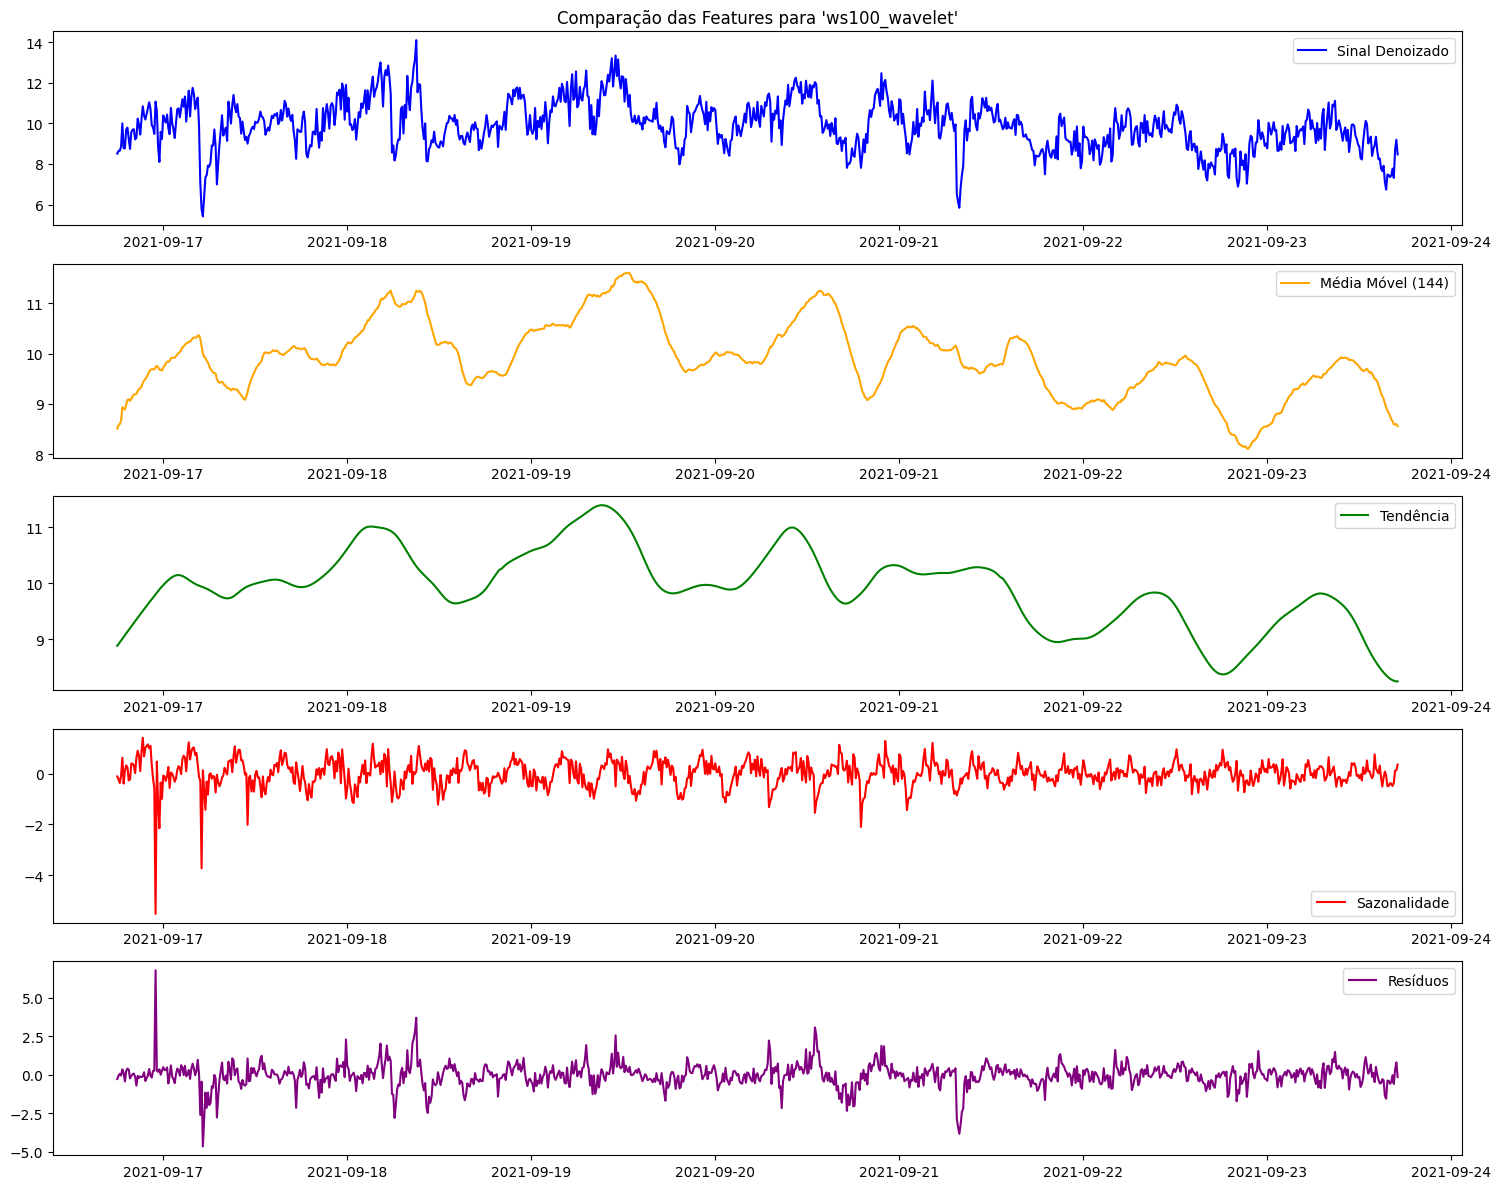

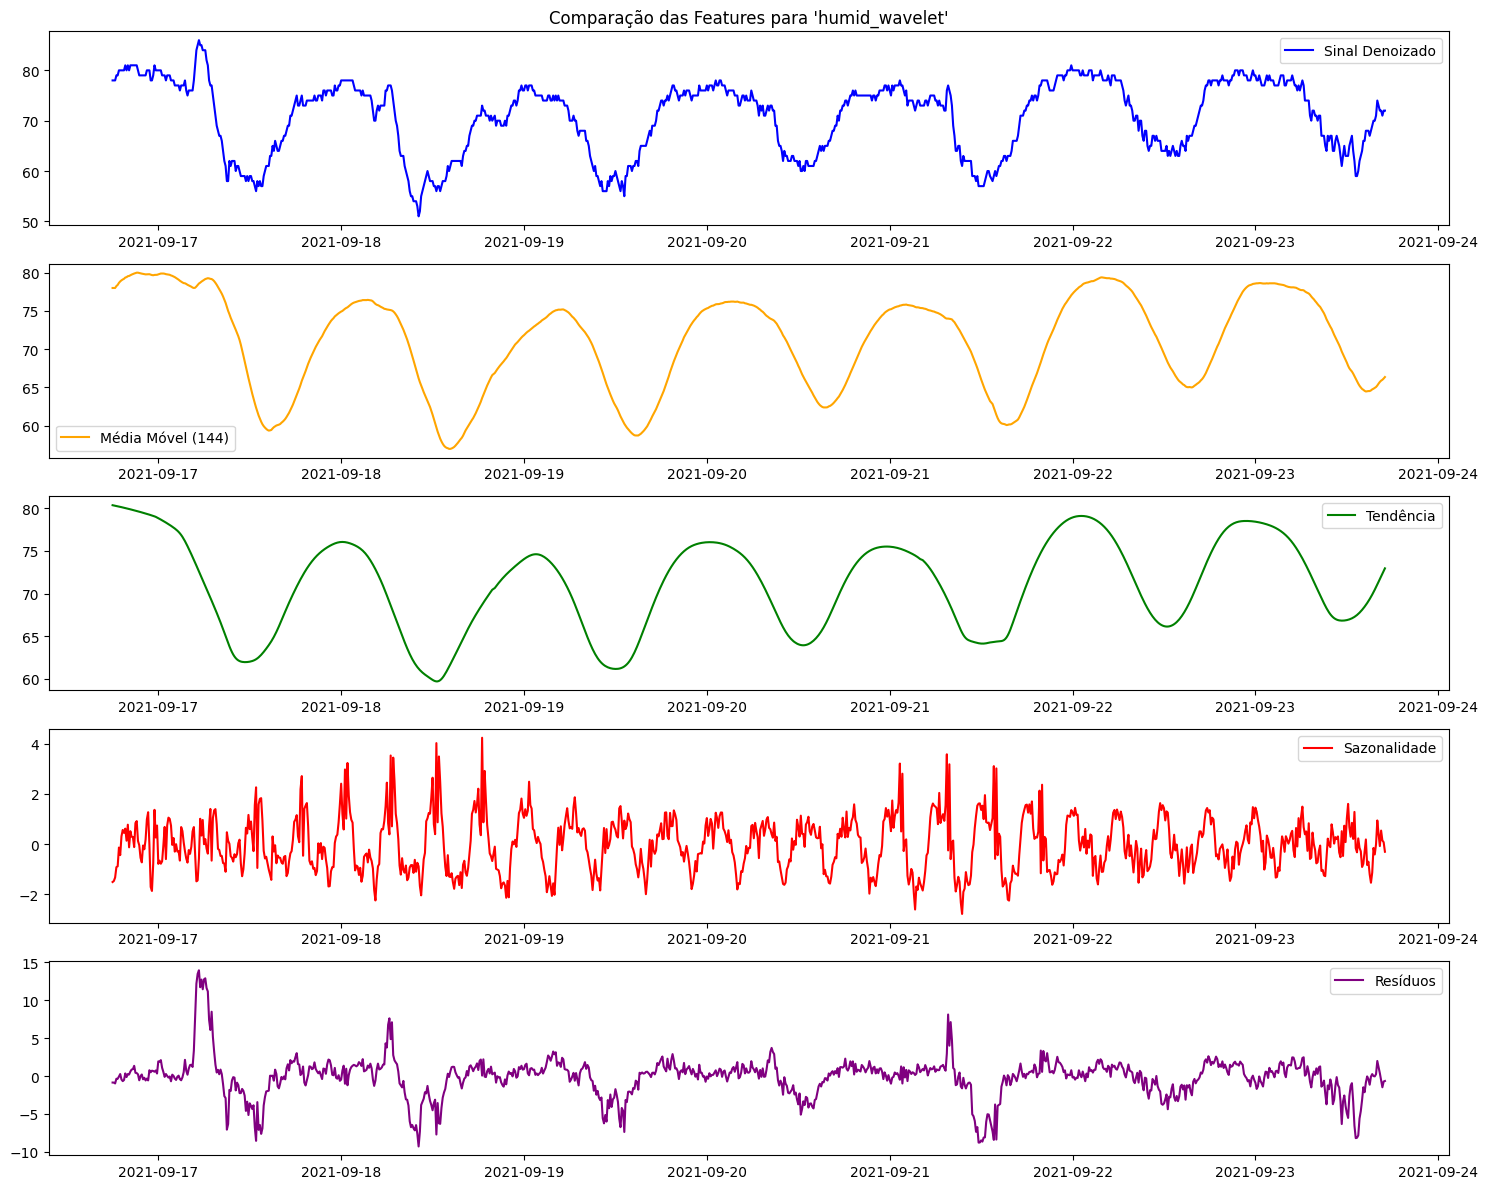

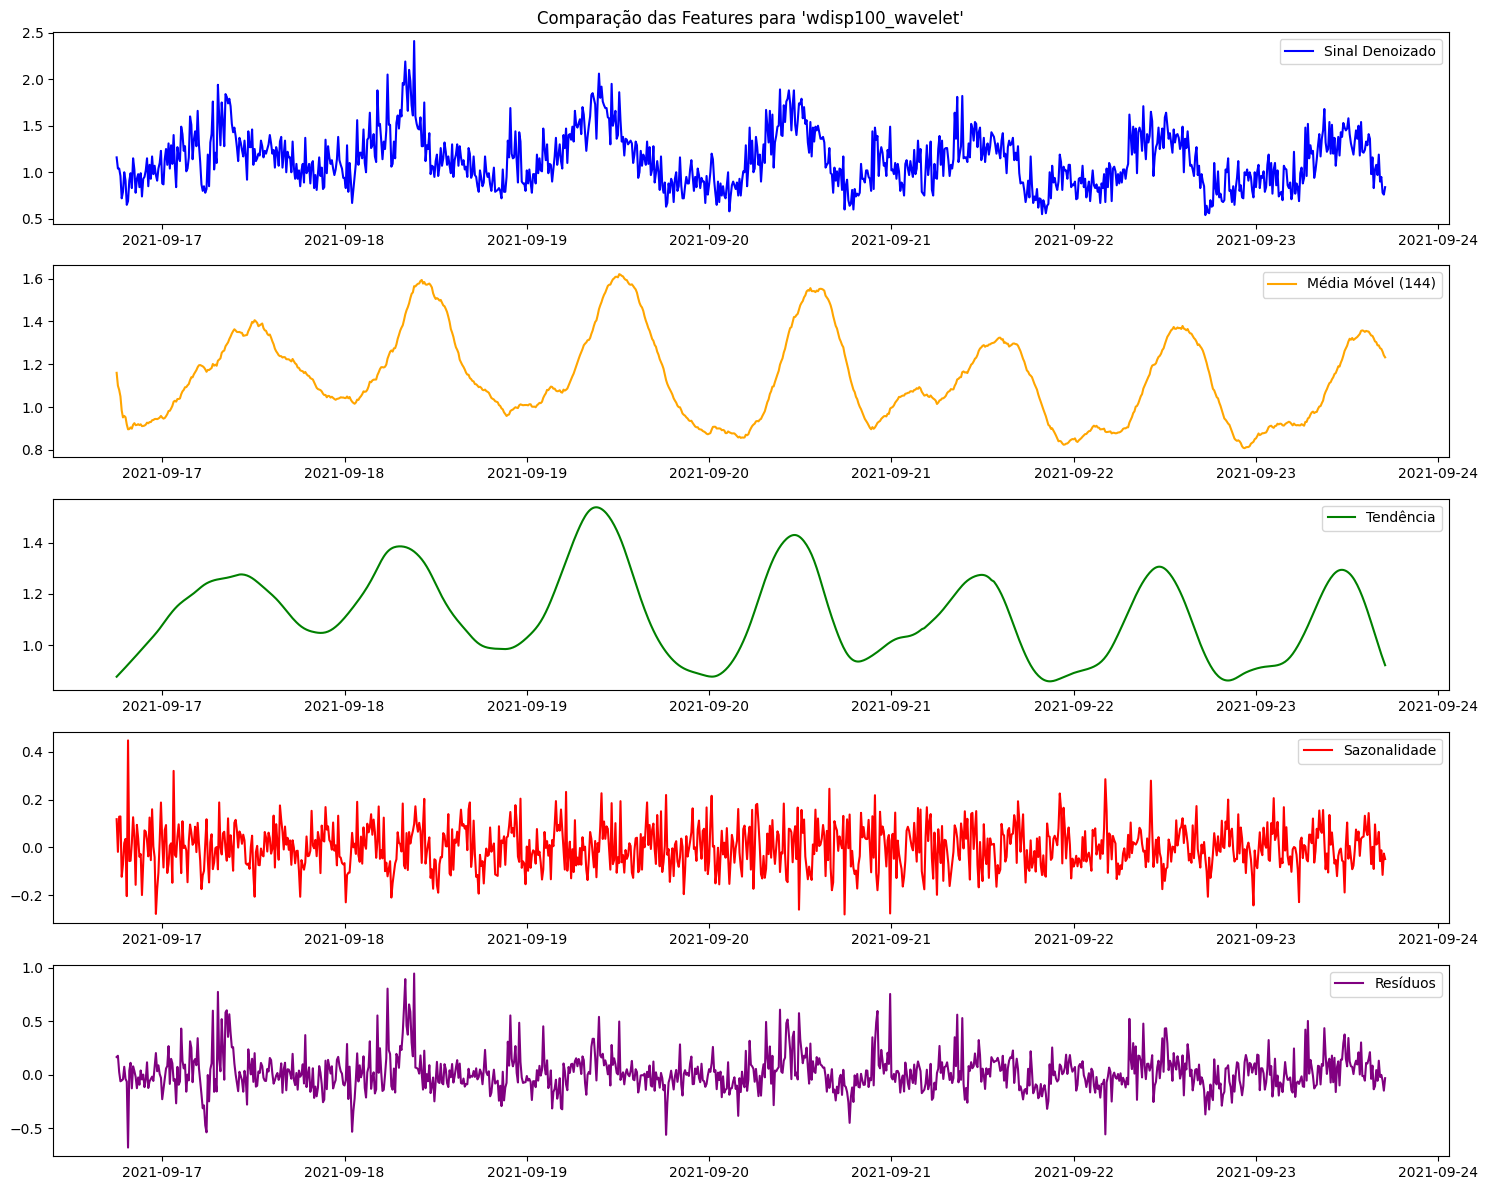

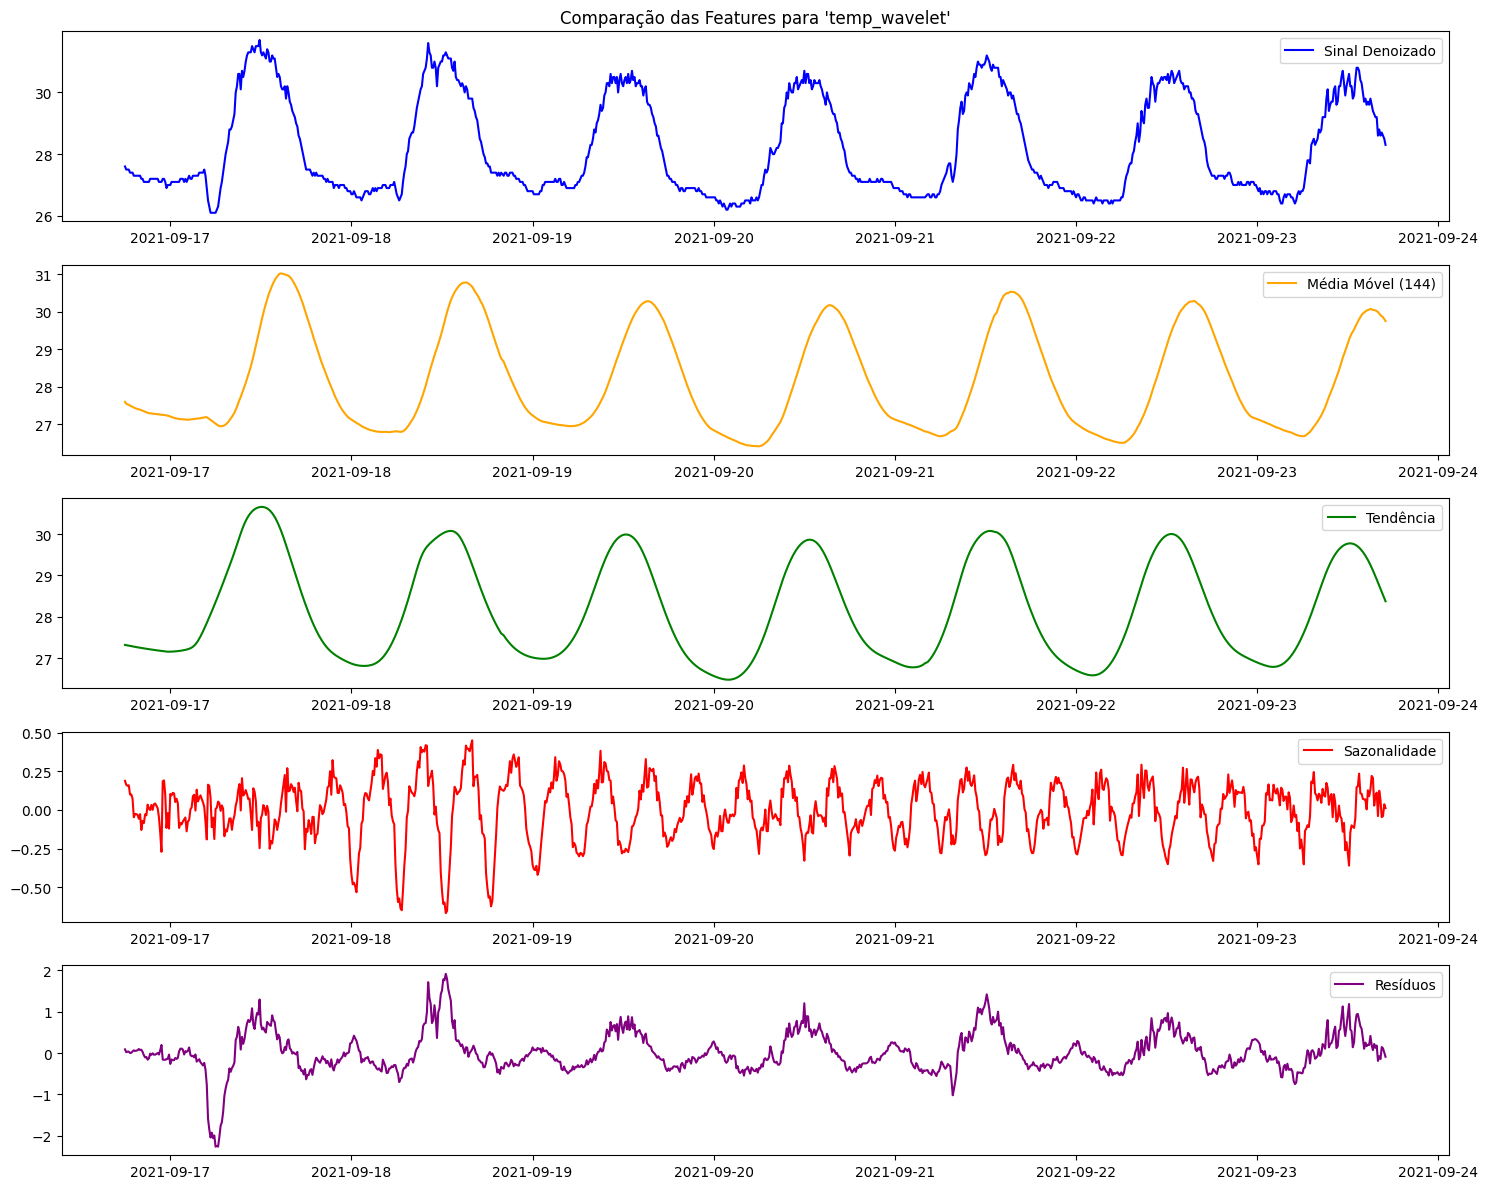

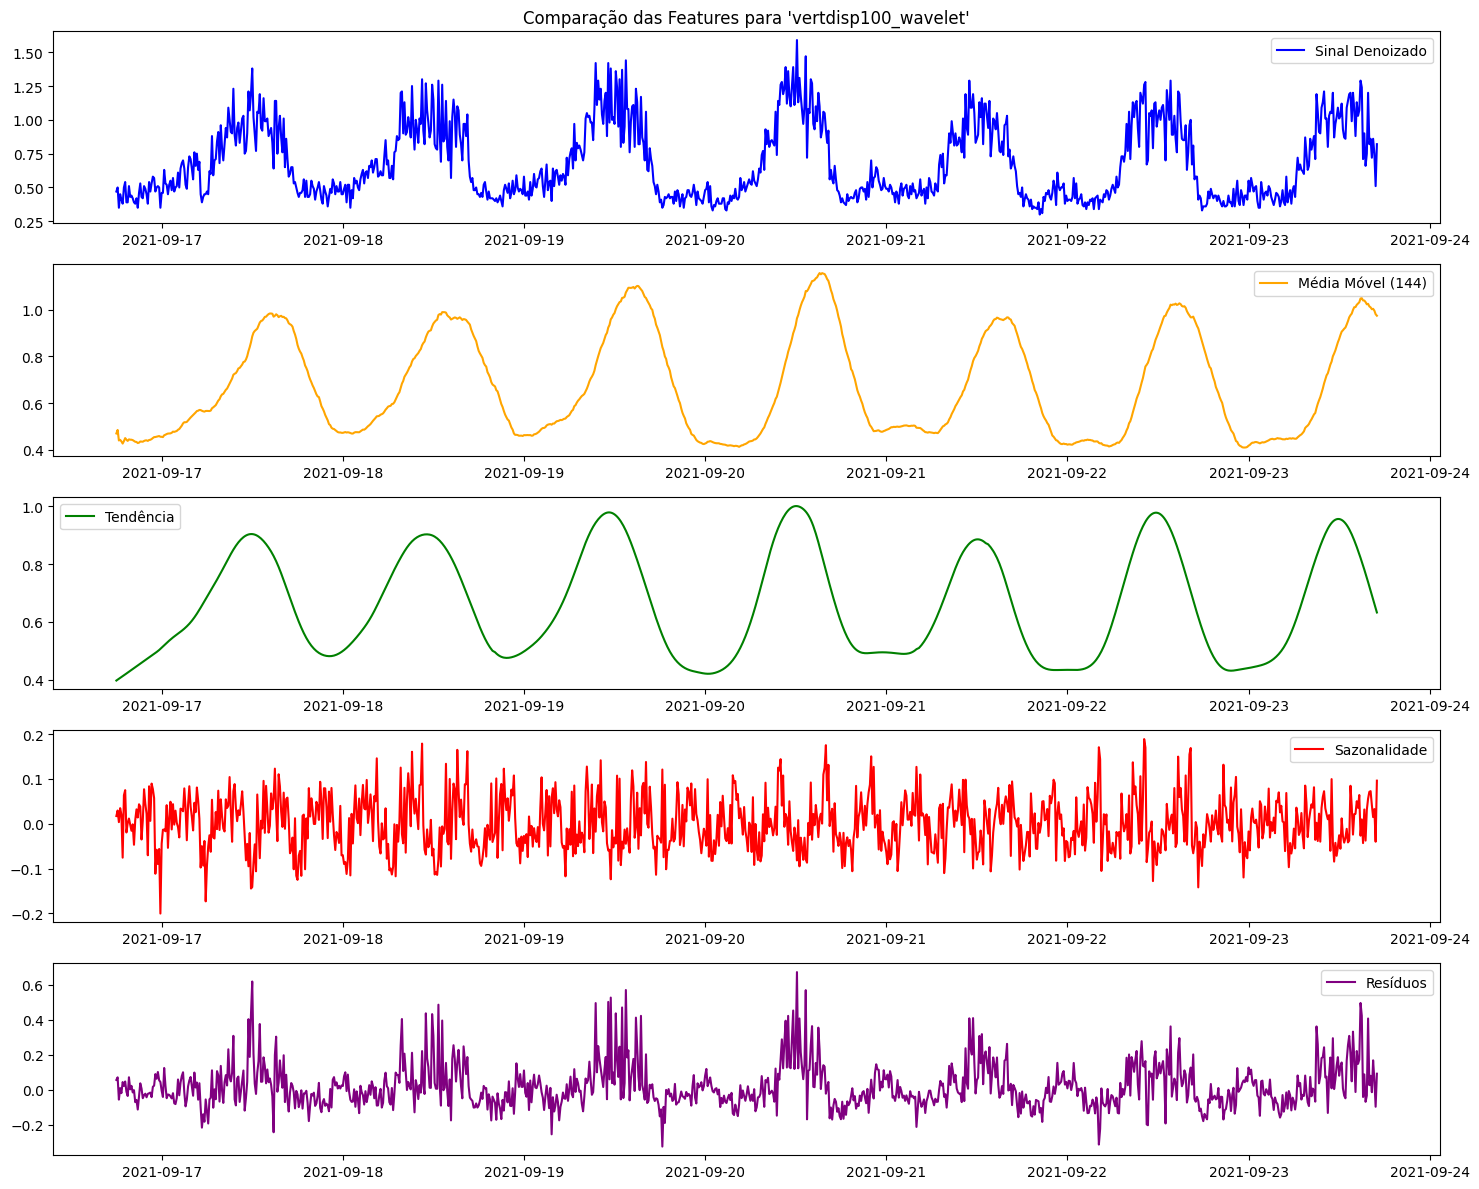

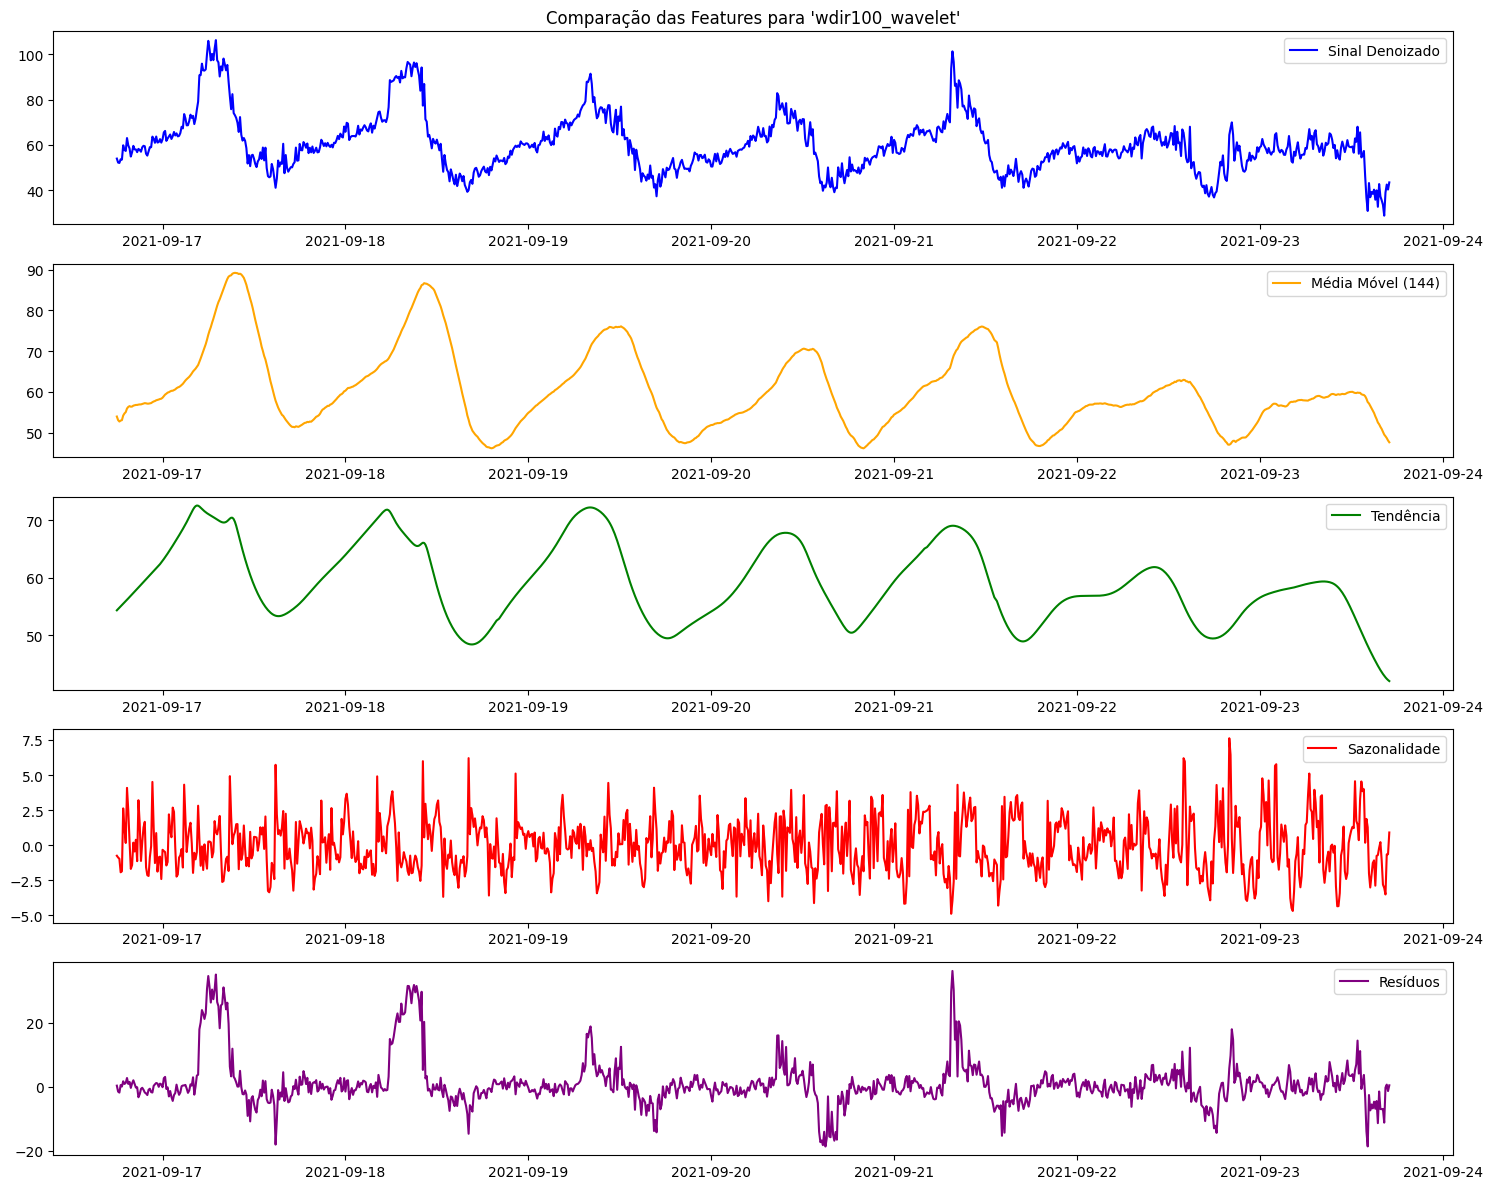

In [18]:

# Plotando o heatmap
plt.figure(figsize=(40, 20))
sns.heatmap(high_corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação das Features com 'ws100_wavelet'")
plt.show()

# Salvando as features com alta correlação em um arquivo CSV
variables_high_corr = variables[high_corr_features.index.tolist() + ['ws100_wavelet']]
variables_high_corr.to_csv("features_alta_correlacao.csv", index=True)

# Função para plotar a comparação entre o sinal original e as features
def plot_feature_comparison(variables, columns_to_denoise, lag=144, sample_size=1000):
    """
    Plota a comparação entre o sinal original denoizado e suas features extraídas.
    
    :param variables: DataFrame contendo os dados e features extraídas.
    :param columns_to_denoise: Lista das colunas denoizadas a serem plotadas.
    :param lag: Valor do lag utilizado para features de defasagem.
    :param sample_size: Número de pontos a serem plotados para clareza.
    """
    for col in columns_to_denoise:
        denoised_col = f'{col}_wavelet'
        trend_col = f'{denoised_col}_trend'
        seasonal_col = f'{denoised_col}_seasonal'
        residual_col = f'{denoised_col}_residual'
        rolling_mean_col = f'{denoised_col}_rolling_mean'
        
        # Verificar se todas as colunas existem no DataFrame
        required_cols = [denoised_col, trend_col, seasonal_col, residual_col, rolling_mean_col]
        if not all(col in variables.columns for col in required_cols):
            print(f"Algumas colunas necessárias para '{denoised_col}' não estão presentes. Pulando.")
            continue
        
        # Selecionar um intervalo de amostra para visualização
        start_idx = 0
        end_idx = sample_size
        if len(variables) < sample_size:
            end_idx = len(variables)
        
        plt.figure(figsize=(15, 12))
        
        # Plot do Sinal Denoizado
        plt.subplot(5, 1, 1)
        plt.plot(variables.index[start_idx:end_idx], variables[denoised_col][start_idx:end_idx], label='Sinal Denoizado', color='blue')
        plt.title(f"Comparação das Features para '{denoised_col}'")
        plt.legend()
        
        # Plot da Média Móvel
        plt.subplot(5, 1, 2)
        plt.plot(variables.index[start_idx:end_idx], variables[rolling_mean_col][start_idx:end_idx], label='Média Móvel (144)', color='orange')
        plt.legend()
        
        # Plot da Tendência
        plt.subplot(5, 1, 3)
        plt.plot(variables.index[start_idx:end_idx], variables[trend_col][start_idx:end_idx], label='Tendência', color='green')
        plt.legend()
        
        # Plot da Sazonalidade
        plt.subplot(5, 1, 4)
        plt.plot(variables.index[start_idx:end_idx], variables[seasonal_col][start_idx:end_idx], label='Sazonalidade', color='red')
        plt.legend()
        
        # Plot dos Resíduos
        plt.subplot(5, 1, 5)
        plt.plot(variables.index[start_idx:end_idx], variables[residual_col][start_idx:end_idx], label='Resíduos', color='purple')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Chamar a função de plotagem
plot_feature_comparison(variables, columns_to_denoise, lag=144, sample_size=1000)
